# Minimum deviation fit example

This example is based on [Template-Fit.ipynb](https://gitlab.rcg.sfu.ca/jsdodge/data-analysis-python/blob/master/notebooks/Template-Fit.ipynb).

## Step 1: Import packages

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2
import warnings

## Step 2: Load the data
### Load the data: examine the format
We will import a set of simulated data produced by [simulate-minimum-deviation.ipynb](https://gitlab.rcg.sfu.ca/jsdodge/data-analysis-python/blob/master/notebooks/simulate-minimum-deviation.ipynb). Change the file name from `mindevdatasim.csv` to the name of the file containing your data.

In [2]:
# Display file contents
file = open('mindevdatasim.csv', 'r')
print(file.read())

theta (deg), delta (deg), delta (min)
45,58,5
50,54,26
55,53,18
60,53,30
65,54,37
70,56,31
75,59,11
80,62,30



### Load the data: import the data into an array
Change the file name from `mindevdatasim.csv` to the name of the file containing your data and adjust the options to match your data file format.

In [3]:
# Load file into array
data = np.genfromtxt('mindevdatasim.csv', delimiter=',', skip_header = 1)
print("data =")
print(data)

data =
[[45. 58.  5.]
 [50. 54. 26.]
 [55. 53. 18.]
 [60. 53. 30.]
 [65. 54. 37.]
 [70. 56. 31.]
 [75. 59. 11.]
 [80. 62. 30.]]


Assign the columns of `data` to new, more meaningful variables. We assign a uniform error of 0.5 minutes of arc here, but you may want to assign an uncertainty to each of your measurements and record it as a separate column in your data file. Also, the input angles here are chosen so that there is no need for an additional column to specify additional minutes of arc, but you may prefer to include this.

In [4]:
# Assign data columns to theta_deg and delta_deg and assign a uniform error of 0.5 minutes of arc to err_deg
theta_deg = data[:,0]
delta_deg = data[:,1] + data[:,2]/60
err_deg = (0.5/60)*np.ones(theta_deg.shape)
print("theta (deg) =", theta_deg)
print("delta (deg) =", delta_deg)
print("err (deg) =", err_deg)

theta (deg) = [45. 50. 55. 60. 65. 70. 75. 80.]
delta (deg) = [58.08333333 54.43333333 53.3        53.5        54.61666667 56.51666667
 59.18333333 62.5       ]
err (deg) = [0.00833333 0.00833333 0.00833333 0.00833333 0.00833333 0.00833333
 0.00833333 0.00833333]


## Step 3: Plot the data
Note that the error bars are smaller than the data markers in this plot.

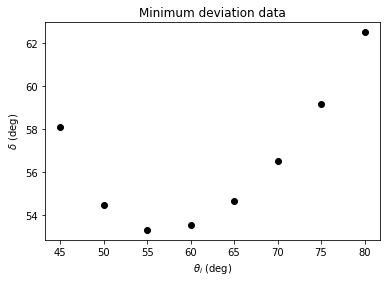

In [5]:
# Plot data
plt.errorbar(theta_deg,delta_deg,yerr=err_deg,fmt='ko')

# Revise the following lines to change the plot format
plt.xlabel('$\\theta_i$ (deg)')
plt.ylabel('$\\delta$ (deg)')
plt.title('Minimum deviation data')

plt.show()

## Step 4: Define the model function
The Python `def` statement below defines our model function,

$$\delta = \theta_i + \sin^{-1}[(n^2 - \sin^2\theta_i)^{1/2}\sin\alpha - \sin\theta_i\cos\alpha] - \alpha.$$

We include both `n` and `alpha_deg` as parameters, so that we can adjust the apex angle if necessary. The trigonometric functions in NumPy assume radian units, not degrees, so we must use the `deg2rad` function from NumPy to convert `theta_deg` and `alpha_deg` into radians for computation, then use `rad2deg` to convert back to degrees at the end.

In [6]:
# theta_deg: Incident angle in degrees
# n        : Refractive index
# alpha_deg: Apex angle in degrees
def model(theta_deg,n,alpha_deg):
    # Convert from degrees to radians
    theta = np.deg2rad(theta_deg) + 0j # Add '0j' to theta so it is
                                       # treated as a complex variable
    alpha = np.deg2rad(alpha_deg)
    delta = theta + np.arcsin(np.sin(alpha)*np.sqrt(n**2-np.sin(theta)**2)- np.sin(theta)*np.cos(alpha)) - alpha
    # Warn the user if the argument of arcsin exceeds one
    if any(np.sin(alpha)*np.sqrt(n**2-np.sin(theta)**2)- np.sin(theta)*np.cos(alpha)>1):
        warnings.warn('Argument to arcsin exceeds one, returning the complex norm')
    #  Take the absolute value and convert to back to degrees
    delta_deg = np.rad2deg(np.absolute(delta))
    return delta_deg

Note that we have introduced a trick to handle cases for which a light ray incident at `theta_deg` will be totally internally reflected by the prism. Mathematically, these values of `theta_deg` will cause the argument of the `arcsin` function to exceed one. As the [arcsin documentation](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.arcsin.html?highlight=arcsin) indicates, the `arcsin` function will return `nan` (ie, not a number) when this occurs for real-valued input. If the `curve_fit` function tries to evaluate the model function for a value of `n` that produces this output, it will generate an error and stop. For *complex-valued input,* however, `arcsin` will return a well-defined *complex-valued output,* such that

$$z = \arcsin u\rightarrow u = \sin z = \frac{e^{iz} - e^{-iz}}{2i}.$$

To convert the argument of `arcsin` from real-valued to complex-valued, we add `0j` to the `theta` variable (Python uses the engineering convention `1j` to represent the complex number $i$), as shown below.

In [7]:
np.arcsin(2)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arcsin
  """Entry point for launching an IPython kernel.


nan

In [8]:
np.arcsin(2+0j)

(1.5707963267948966+1.3169578969248166j)

This change will allow the fit routine to continue if the argument to the `arcsin` function exceeds one, but since the result in that case is physically impossible, we issue a warning so that the user knows there is a problem. The result for `delta` in this case will have a nonzero imaginary part, which we handle by taking the absolute value; if the argument to the `arcsin` function is less than one, then `delta` will be a real, positive number and the absolute value operation leaves it unchanged.

## Step 5: Choose initial parameter values for the model
Select your initial parameters, select an appropriate range for your independent variable, and check that the resulting model curve is reasonably close to your data. Adust and repeat if they don't match.

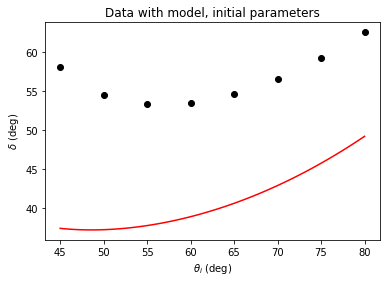

In [9]:
# Set initial parameter n and constant alpha
nInit = 1.5
alpha_deg_const = 60

# Define new frequency array, fModel, for displaying the model
thetaModel = np.linspace(45,80,100)

# Make the plot
plt.plot(thetaModel,model(thetaModel,nInit,alpha_deg_const),'r-')
plt.errorbar(theta_deg,delta_deg,yerr=err_deg,fmt='ko')

# Label axes and give it a title for notebook (remove it when including the plot in a report)
plt.xlabel('$\\theta_i$ (deg)')
plt.ylabel('$\\delta$ (deg)')
plt.title('Data with model, initial parameters')

plt.show()
# Now go back to the top and change nInit to improve the fit!

## Step 6: Fit the model to the data
See the [help](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) for details on the `curve_fit` function. Its basic syntax is

`curve_fit(f, xdata, ydata)`,

where `f` is the model function, `xdata` the measurements of the independent variable, and `ydata` the measurements of the dependent variable. Moreover, the first input to `f` must be the independent variable, and `curve_fit` interprets all remaining inputs to `f` as fit parameters. If we were to use our current definition of `model`, for example, the first input `theta_deg` would correctly be understood by `curve_fit` to be the independent variable, and both `n` and `alpha_deg` would be understood to be fit parameters.

While it's nice to have control over `alpha_deg` in our model, it is specified by the manufacturer to be 60 degrees, so it is preferable to fix `alpha_deg` at `alpha_deg_const` and just fit for `n`. To do this without writing an entirely new `def` expression, we use the [lambda expression](https://docs.python.org/3/reference/expressions.html#lambda) `lambda theta_deg, n: model(theta_deg,n,alpha_deg_const)` to define a new, *anonymous function* (ie, it does not have a name) as the first input to `curve_fit`, which in turn has input parameters `theta_deg, n` and returns `model(theta_deg,n,alpha_deg_const)`.

In [10]:
# Fix alpha_deg to alpha_deg_const, fit the resulting model to the data,
# and display the results. Each input to curve_fit is shown on a separate
# line with explanatory comments.
nOpt, nVar = curve_fit(
    lambda theta_deg, n: model(theta_deg,n,alpha_deg_const), # Model with alpha_deg fixed\
    theta_deg,              # Independent variable
    delta_deg,              # Dependent variable
    p0=nInit,               # Initial parameter guess
    sigma=err_deg,          # Uncertainty in dependent variable
    absolute_sigma=True)    # Assume uncertainties in delta_deg are known independently
print("nOpt =", nOpt)
print("nVar =", nVar)

nOpt = [1.67005522]
nVar = [[6.71019375e-10]]


Convert output from arrays to scalars, determine standard error, and display formatted results.

In [11]:
nOpt = nOpt[0]
nAlpha = np.sqrt(nVar[0,0])
print("Default precision:")
print("Refractive index estimate:    ", nOpt, " ± ", nAlpha)

Default precision:
Refractive index estimate:     1.6700552172145653  ±  2.590404166719802e-05


_**Note that you should always round such parameter estimates and uncertainties to the appropriate number of significant figures!**_

Follow the "golden rules" described in Sec. 2.9 of Hughes and Hase, adapted to the model-fitting context.

1. *If and only if the fit between a model and the data is good* (see below for methods to assess fit quality), the best estimate of a parameter is the one returned by the fit, and may be understood as the mean value of the distribution that you would get if you were to conduct the same experiment many times.
2. The error in each parameter is given by the square root of the associated diagonal element of the covariance matrix, and may be understood as the standard error for the parameter. Correlation coefficients between parameters may also be derived from the covariance matrix, using Eq. (7.30) in Hughes and Hase.
3. Round up the error for each parameter to the appropriate number of significant figures (usually just one, but sometimes more—see the discussion on p. 17 of Hughes and Hase, including Footnote #7).
4. Match the number of decimal places in the mean to the standard eror.
5. Include units.

We can print a result that follows these rules using the syntax below:

In [12]:
print("Refractive index estimate:    %.5f ± %.5f" % (nOpt, nAlpha))

Refractive index estimate:    1.67006 ± 0.00003


The `%.5f` strings are known as a *format strings*. The `%` tells the interpreter that formatting information follows; the `.5f` then tells the interpreter to format the numerical input in floating-point notation to five decimal places. The numerical inputs are then given as a tuple after an additional `%` character, to indicate that they are to be interpreted as inputs to the preceding format string. Examples of the most common numerical format strings are below.

In [13]:
print("Field width=10, precision=5, floating point format:%10.5f ±%10.5f" % (nOpt, nAlpha))
print("Field width=10, precision=5, scientific notation format:%10.5e ±%10.5e" % (nOpt, nAlpha))
print("Field width=10, precision=5, the more compact of e or f format:%10.5g ±%10.5g" % (nOpt, nAlpha))
print("Field width=10, signed integer format:%10d ±%10d" % (nOpt, nAlpha))

Field width=10, precision=5, floating point format:   1.67006 ±   0.00003
Field width=10, precision=5, scientific notation format:1.67006e+00 ±2.59040e-05
Field width=10, precision=5, the more compact of e or f format:    1.6701 ±2.5904e-05
Field width=10, signed integer format:         1 ±         0


## Step 7: Assess the fit
### Assessing the fit: visual inspection

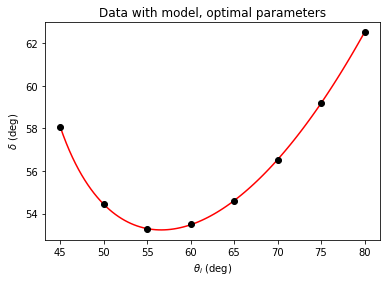

In [14]:
# Plot data with best-fit model
plt.plot(thetaModel,model(thetaModel,nOpt,alpha_deg_const),'r-')
plt.errorbar(theta_deg,delta_deg,yerr=err_deg,fmt='ko')

plt.xlabel('$\\theta_i$ (deg)')
plt.ylabel('$\\delta$ (deg)')
plt.title('Data with model, optimal parameters')

plt.show()

### Assessing the fit: compute the $\chi^2$ statistic
Change the definition of `res` to match your dependent variable and model function.

In [15]:
# Compute and display chi-squared
res = delta_deg - model(theta_deg,nOpt,alpha_deg_const)
normres = res/err_deg
chisq = np.sum(normres**2)
print("chi-squared = %.1f" % chisq)

chi-squared = 14.1


Compare to the number of statistical degrees of freedom.

In [16]:
# Compute and display DOF
Ndata = np.size(delta_deg)
Npar = np.size(nOpt)
dof = Ndata - Npar
print("dof = %d" % dof)

dof = 7


This gives a *reduced chi-squared* of $\chi_\nu^2=\chi^2_\text{min}/\nu \approx 2$. As discussed in Sec. 8.4 of Hughes and Hase, consistency requires $\chi_\nu^2 \approx 1$, but this does not provide very clear guidance in this case: is $2\approx 1$, or is $2\gg 1$?  A more quantitative approach is to use the *cumulative distribution function* of the $\chi^2$ distribution, `chi2.cdf(chisq,dof)`, to determine the fraction of times that a fit with `dof` degrees of freedom will yield a value for $\chi_\text{min}^2$ less than or equal to `chisq`.

In [23]:
cdf = chi2.cdf(chisq,dof)
print("Cumulative probability = %.3f" % cdf)
print("Significance: %.3f" % (1 - cdf))

Cumulative probability = 0.951
Significance: 0.049


This tells us that we should expect to get $\chi^2 = 14.1$ or less 95.1&nbsp;% of the time when the data is well-described by the model, and greater than this only 4.9&nbsp;% of the time. We call this 4.9&nbsp;% probability the *significance* of the $\chi^2$ test for $\chi^2_\text{min} = 14.1$ and $\nu = 7$. The significance level may be understood as the probability of rejecting a fit erroneously, as a result of an unusually large statistical fluctuation in the data. A common convention is to reject any fit that falls below 5&nbsp;% significance. By this standard our fit is marginal: it's not an obviously bad fit, but neither is it particularly good.

### Assessing the fit: plot the (normalized) residuals
Finally, we can check for statistical consistency by confirming that the residuals do not show any systematic pattern.

The following cell uses the PyPlot `stem` routine to produce the residual plot, which often shows deviations from the zero line more effectively than a regular scatterplot.

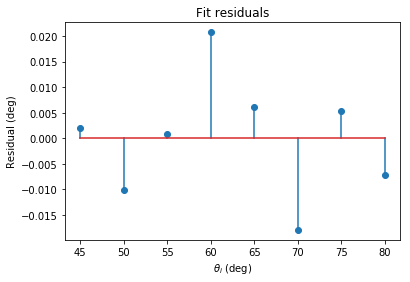

In [18]:
# Show residuals
plt.stem(theta_deg,res)

plt.xlabel('$\\theta_i$ (deg)')
plt.ylabel('Residual (deg)')
plt.title('Fit residuals')

plt.show()

Plotting the normalized residuals makes it easier to evaluate the fit. In this case we have assumed the point uncertainty is constant for each measurement, so the main simplification is to rescale the ordinate so that the estimated uncertainty is equal to one. See [Example-Fit.ipynb](https://gitlab.rcg.sfu.ca/teaching/data-analysis-python/Template-Fit.ipynb) for an example in which the point uncertainty varies across the measurements.

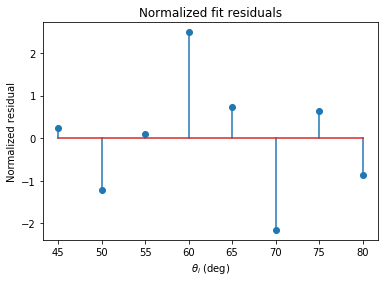

In [19]:
# Show normalized residuals
plt.stem(theta_deg,normres)

plt.xlabel('$\\theta_i$ (deg)')
plt.ylabel('Normalized residual')
plt.title('Normalized fit residuals')

plt.show()

It can be helpful to stack the data plot and the residual plot for comparison. The simplest way to do this is with the [`subplots`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html) and [`subplot`](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.subplot) functions.

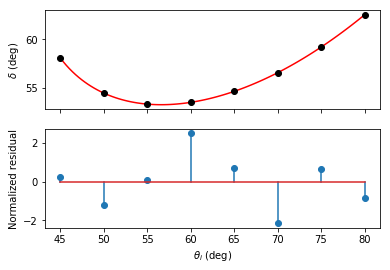

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, squeeze=True)
plt.subplot(2,1,1)
plt.plot(thetaModel,model(thetaModel,nOpt,alpha_deg_const),'r-')
plt.errorbar(theta_deg,delta_deg,yerr=err_deg,fmt='ko')

plt.ylabel('$\\delta$ (deg)')
plt.tick_params(       # Use this to disable tick labels for x-axis
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are on
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.subplot(2,1,2)
plt.stem(theta_deg,normres)

plt.xlabel('$\\theta_i$ (deg)')
plt.ylabel('Normalized residual')

plt.show()

You can customize the layout with [`GridSpec`](https://matplotlib.org/users/gridspec.html) by using the the `subplot2grid` helper function.

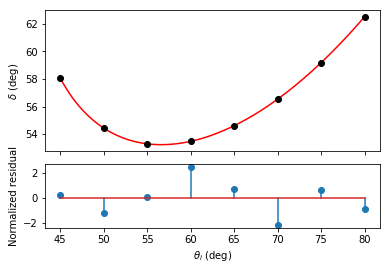

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, squeeze=True)
plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plt.plot(thetaModel,model(thetaModel,nOpt,alpha_deg_const),'r-')
plt.errorbar(theta_deg,delta_deg,yerr=err_deg,fmt='ko')

plt.ylabel('$\\delta$ (deg)')
plt.tick_params(       # Use this to disable tick labels for x-axis
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are on
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.subplot(3,1,3)
plt.stem(theta_deg,normres)

plt.xlabel('$\\theta_i$ (deg)')
plt.ylabel('Normalized residual')

plt.show()

When you are happy with the layout, you can save the figure using the [`savefig`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.savefig.html?highlight=savefig#matplotlib.pyplot.savefig) method. Note that we apply this method to the figure handle `fig` that was created by the `subplots` function in the preceding cell. We could also use `plt.savefig`, but only *before* executing `plt.show()`, since that function resets the current figure handle to a blank figure.

In [22]:
fig.savefig("mindevfit.eps")

## Step 8: Decide what to do next
Ideally you will get to the end of this whole process and find that the model fits the data well, and you can report your results with confidence. If time allows, you might even go back and take more data to improve the precision of your parameter estimates. But what happens if your $\chi^2$ statistic is too big or too small, or if the normalized residuals do not appear random? If that's the case, you have a few options:

* Look for defects in your experimental procedure, including the procedure you used to prepare the raw data for analysis (ie, incorrect unit conversion).
* Consider a different model. This may include changes that are based on physical reasoning, such as eliminating approximations to make it more realistic, or purely empirical, such as adding a constant background, or an extra term in a polynomial fit. The residuals should provide guidance on how to change the functional relationship to improve agreement. Just don't overdo it: if you find yourself needing to add many arbitrary fit parameters to achieve a good fit, that is usually a sign that you need to consider a different approach.
* Consider restricting your fit to a narrower range of measurements (i.e., focus on limiting values of $x$ and/or $y$, or on the heights, widths and locations of peaks instead of their detailed shape).
* Consider rescaling the uncertainties, as described in Sec. 8.9 of Hughes and Hase (though note their "health warning" in Footnote 9).
* Accept that you may be unable to remove all sources of systematic error in the given time, and do your best to make a quantitative estimate of your parameter uncertainties in light of them. You don't have to throw all of your data away just because you don't have a model that fits it well.